In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
st_iter = pd.read_csv("dataset/salida2.csv", chunksize=1000000)

## Cantidad de bicis

Queremos saber cuántas bicicletas hay en función del tiempo. Para eso tenemos:

- en status.csv disponemos de la cantidad de bicicletas disponibles en un minuto dado.
- en trips.csv tenemos los viajes en todo momento.

Podemos medir, a las 3 am de todos los días (para minimizar ruido) cuántas bicicletas hay. **NOTA** Podemos usar un _daterange para esto_.

### Análisis previo: a qué horas hay más bicis en viaje?

Para medir esto levantamos trips.csv y analizamos cada media hora cuántos viajes hay. Primero hagámoslo a las 3. Después vemos cómo lo mejoramos para que sea en todos.

In [6]:
viajes = pd.read_csv("dataset/trip.csv")

In [7]:
# Veamos qué estilo tiene.
viajes.head(3)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214


In [8]:
# Y qué tipos.
viajes.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

### Arreglemos las fechas.
Esto debería ser cuestión de, al leer, especificar fechas. Por ahí sea importante tener en cuenta que el formato de fecha es mes/dia/año (oh god why).

Se le especifica que infiera los formatos de fecha, lo cual acelera considerablemente el proceso.

In [4]:
viajes = pd.read_csv("dataset/trip.csv", parse_dates=["start_date", "end_date"], 
                     infer_datetime_format=True)
viajes.dtypes

id                             int64
duration                       int64
start_date            datetime64[ns]
start_station_name            object
start_station_id               int64
end_date              datetime64[ns]
end_station_name              object
end_station_id                 int64
bike_id                        int64
subscription_type             object
zip_code                      object
dtype: object

In [63]:
viajes.end_date.head(3)

0   2013-08-29 14:14:00
1   2013-08-29 14:43:00
2   2013-08-29 10:17:00
Name: end_date, dtype: datetime64[ns]

Perfecto, las fechas fueron parseadas y comprobamos que se corrigieron al formato japonés.

### Cosas que suceden a las 4 de la mañana
¿Cómo se filtra una columna por fechas? Nuestra idea es que queden en la columna las cosas que arrancan antes de las 4:00 y terminan después de las 4:00. Tenemos que comparar fechas.

In [37]:
a = np.datetime64("2013-01-01 09:59:59")
b = np.datetime64("2013-01-01 10:00:00")
c = np.datetime64("2013-01-01 10:00:01")

a < b < c

True

Tres fechas cualesquiera se pueden comparar desde arriba. Y si solo nos importa el **tiempo/hora** y no **el día** para filtrar?

In [58]:
a = np.datetime64("2013-01-01 10:00:00")
b = np.datetime64("2013-01-02 10:00:00")

print(a<b)
print(a.tolist().time() < b.tolist().time())

True
False


Perfecto. Esto nos sirve para ver si algo está a las 4 de la mañana. Intentamos filtrar por esa condición.

In [92]:
viajes4am = viajes[(viajes.start_date.dt.hour < 4) & (4 <= (viajes.end_date.dt.hour))]
len(viajes4am)

289

In [99]:
viajes4am = viajes4am.reset_index()

**Problema**: Esas no son todas. Una bicicleta puede haber sido alquilada por 3 días. Podemos hacer algo al estilo map-reduce.

1. Map: Por cada una se hace una lista con las horas por las que pasa.
2. ReduceByKey: Se cuenta la cantidad de apariciones de cada hora.

In [4]:
# Suma de apariciones de cada hora en las listas.
suma = [0]*24

def horas(viaje):
    # Obtengo la hora más cercana por arriba al inicio.
    startf = viaje.start_date.ceil("H")
    # Hora más cercana por abajo al fin.
    endf = viaje.end_date.floor("H")
    rango = pd.date_range(start=startf, end=endf, freq="H").hour
    # Sumamos 1 a las apariciones de cada hora en el rango.
    for h in rango:
        suma[h]+=1

Dato interesante: cuando un apply devuelve una serie, se crea una columna por cada elemento, permitiendo labels. Esto puede ser muy util para otros casos. Acá es peligroso porque se genera un dataframe disperso con muchísimas columnas.

In [6]:
viajes.apply(horas, axis=1);

In [7]:
suma

[5421,
 4538,
 4437,
 4161,
 4081,
 4207,
 5485,
 10268,
 25354,
 36833,
 20502,
 17957,
 23667,
 26990,
 26942,
 27284,
 32827,
 42876,
 38695,
 22753,
 13998,
 10079,
 7993,
 6308]

In [5]:
suma = [5421,
 4538,
 4437,
 4161,
 4081,
 4207,
 5485,
 10268,
 25354,
 36833,
 20502,
 17957,
 23667,
 26990,
 26942,
 27284,
 32827,
 42876,
 38695,
 22753,
 13998,
 10079,
 7993,
 6308]

<IPython.core.display.Javascript object>


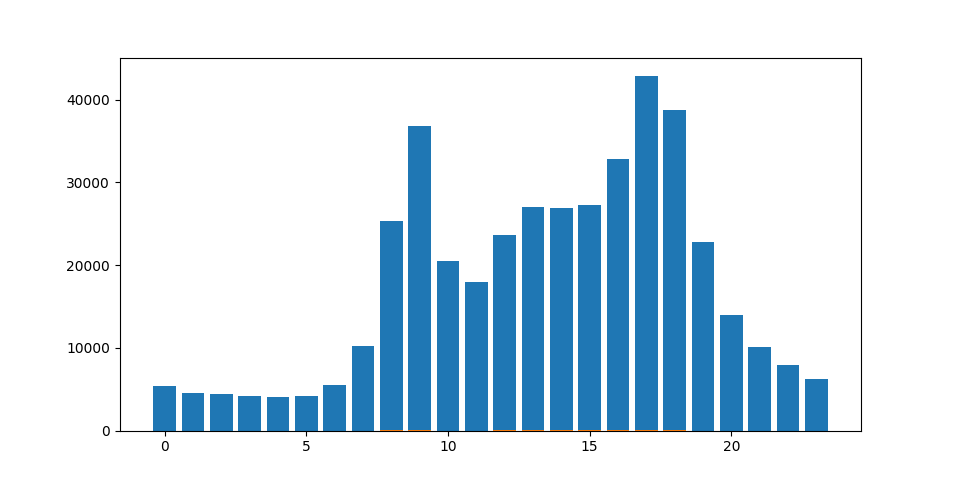

<Container object of 24 artists>

In [15]:
plt.bar(left=[x for x in range(len(suma))], height=suma)

In [20]:
totalDias = len(viajes.start_date.dt.date.unique())

In [22]:
cantBicicletasPorHora = [s/totalDias for s in suma]

<IPython.core.display.Javascript object>


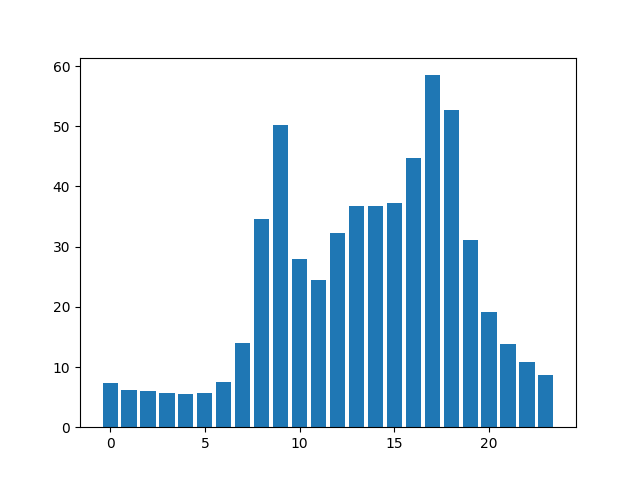

<Container object of 24 artists>

In [145]:
plt.figure("Cantidad de bicicletas alquiladas en cada hora")
plt.bar([x for x in range(len(cantBicicletasPorHora))], cantBicicletasPorHora)

### Tiempo máximo de Viaje

Vemos que start_date y end_date son precisas a nivel minutos, duration a nivel segundos.

In [34]:
viajes[["start_date","end_date","duration"]]

,start_date,end_date,duration
0,2013-08-29 14:13:00,2013-08-29 14:14:00,63
1,2013-08-29 14:42:00,2013-08-29 14:43:00,70
2,2013-08-29 10:16:00,2013-08-29 10:17:00,71
3,2013-08-29 11:29:00,2013-08-29 11:30:00,77
4,2013-08-29 12:02:00,2013-08-29 12:04:00,83
5,2013-08-29 18:54:00,2013-08-29 18:56:00,103
6,2013-08-29 13:25:00,2013-08-29 13:27:00,109
7,2013-08-29 14:02:00,2013-08-29 14:04:00,111
8,2013-08-29 17:01:00,2013-08-29 17:03:00,113
9,2013-08-29 11:33:00,2013-08-29 11:35:00,114


In [40]:
viajesMasCortos = viajes.sort_values("duration").head(10)[["start_date","end_date","duration"]]
viajesMasCortos

,start_date,end_date,duration
301480,2014-03-18 17:50:00,2014-03-18 17:51:00,60
252114,2014-05-14 20:11:00,2014-05-14 20:12:00,60
79739,2013-11-28 09:52:00,2013-11-28 09:53:00,60
618094,2014-10-20 08:16:00,2014-10-20 08:17:00,60
547555,2015-01-14 12:37:00,2015-01-14 12:38:00,60
511423,2015-02-21 12:45:00,2015-02-21 12:46:00,60
413341,2015-05-29 14:45:00,2015-05-29 14:46:00,60
510302,2015-02-23 14:12:00,2015-02-23 14:13:00,60
10457,2013-09-12 10:09:00,2013-09-12 10:10:00,60
509279,2015-02-24 09:18:00,2015-02-24 09:19:00,60


In [47]:
viajes[viajes.duration == 60]

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
2887,8576,60,2013-09-02 09:40:00,Harry Bridges Plaza (Ferry Building),50,2013-09-02 09:41:00,Harry Bridges Plaza (Ferry Building),50,354,Subscriber,94102
2925,8651,60,2013-09-02 10:50:00,San Francisco Caltrain 2 (330 Townsend),69,2013-09-02 10:51:00,San Francisco Caltrain 2 (330 Townsend),69,544,Subscriber,94107
3535,9444,60,2013-09-03 08:37:00,Redwood City Public Library,24,2013-09-03 08:38:00,Redwood City Public Library,24,239,Subscriber,94105
7296,14644,60,2013-09-08 13:55:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-08 13:56:00,San Francisco Caltrain (Townsend at 4th),70,521,Subscriber,95126
10457,18792,60,2013-09-12 10:09:00,Civic Center BART (7th at Market),72,2013-09-12 10:10:00,Civic Center BART (7th at Market),72,632,Subscriber,94103
11545,20271,60,2013-09-13 12:43:00,Market at 4th,76,2013-09-13 12:44:00,Market at 4th,76,500,Subscriber,94116
13437,22689,60,2013-09-15 21:15:00,Embarcadero at Sansome,60,2013-09-15 21:16:00,Embarcadero at Sansome,60,577,Subscriber,94111
20568,32159,60,2013-09-23 18:53:00,Townsend at 7th,65,2013-09-23 18:54:00,Townsend at 7th,65,566,Subscriber,94107
40000,57581,60,2013-10-14 14:47:00,Clay at Battery,41,2013-10-14 14:48:00,Clay at Battery,41,368,Subscriber,94158
55127,77650,60,2013-10-30 18:22:00,Harry Bridges Plaza (Ferry Building),50,2013-10-30 18:23:00,Harry Bridges Plaza (Ferry Building),50,416,Subscriber,94110


In [43]:
viajesMasLargos = viajes.sort_values("duration").tail(10)[["start_date","end_date","duration"]]
viajesMasLargos.duration /= (3600*24)
viajesMasLargos

,start_date,end_date,duration
524521,2015-02-08 03:05:00,2015-02-15 17:17:00,7.591887
421839,2015-05-20 15:27:00,2015-05-28 14:49:00,7.973368
195379,2014-07-13 05:50:00,2014-07-21 12:32:00,8.279387
223016,2014-06-13 16:57:00,2014-06-21 23:59:00,8.292593
606063,2014-10-30 08:29:00,2014-11-07 15:36:00,8.338588
80510,2013-11-30 13:29:00,2013-12-08 22:06:00,8.359213
371066,2015-07-10 10:35:00,2015-07-23 13:27:00,13.119676
440339,2015-05-02 06:17:00,2015-05-23 16:53:00,21.442014
382718,2015-06-28 21:50:00,2015-07-23 15:27:00,24.733796
573566,2014-12-06 21:59:00,2015-06-24 20:18:00,199.888889



### Zip_codes
_A ver en otro momento si es necesario_
Por que el zip code no figura como numérico? vamos a ver casos que no lo sean.

In [19]:
zip_codes_fallados = viajes.loc[pd.to_numeric(viajes.zip_code, errors="coerce").isnull(), "zip_code"]

In [21]:
zip_codes_fallados.value_counts()

nil           10682
94040-1724      275
94103-2585       60
v6z2x            25
94107-3471       10
946-2             4
M4S1P             2
Name: zip_code, dtype: int64

Bueno, por ahora no vamos a tocar los zip-codes. No nos sirven. Y son alto bardo. Algunos no están implícitamente, otros no están explícitamente (nil, son muchos) y otros son compuestos.

### Cantidad de dias por semana
Contar la cantidade viernes _distintos_.

In [146]:
# Total de viajes por día.
viajes["week_day"] = viajes.start_date.dt.weekday_name
agrupadosPorWeekday= viajes.groupby("week_day")
alquileresPorDia = agrupadosPorWeekday.size()
alquileresPorDia

week_day
Friday       109361
Monday       115873
Saturday      44785
Sunday        38391
Thursday     119089
Tuesday      122259
Wednesday    120201
dtype: int64

In [67]:
fechasDistintas = pd.DataFrame({"fecha": viajes.start_date.dt.date, "week_day": viajes.week_day})


In [103]:
cantDias = fechasDistintas.groupby(["week_day","fecha"]).agg(lambda x:1).reset_index().week_day.value_counts()
cantDias

Friday       105
Sunday       105
Thursday     105
Saturday     105
Monday       105
Wednesday    104
Tuesday      104
Name: week_day, dtype: int64

In [108]:
# Ordeno
cantDias = cantDias.sort_index()
cantDias

Friday       105
Monday       105
Saturday     105
Sunday       105
Thursday     105
Tuesday      104
Wednesday    104
Name: week_day, dtype: int64

In [113]:
alquilerPromedioPorDia = alquileresPorDia / cantDias
alquilerPromedioPorDia

week_day
Friday       1041.533333
Monday       1103.552381
Saturday      426.523810
Sunday        365.628571
Thursday     1134.180952
Tuesday      1175.567308
Wednesday    1155.778846
dtype: float64

In [175]:
def ordenarIndiceDias(tabla):
    dias = ["Monday", "Tuesday", "Thursday", "Wednesday", "Friday", "Saturday", "Sunday"]
    indexNuevo = pd.Categorical(tabla.index, categories = dias)
    tabla.index = indexNuevo
    tabla.sort_index(inplace = True)

In [178]:
ordenarIndiceDias(alquilerPromedioPorDia)

<IPython.core.display.Javascript object>


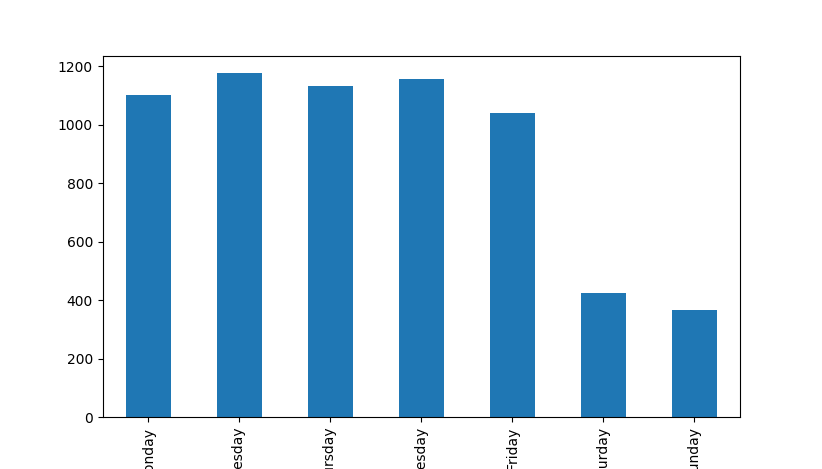

In [179]:
plt.figure("Alquileres promedio por Día")
alquilerPromedioPorDia.plot.bar()

### Tipo de suscriptores

In [185]:
viajes.subscription_type.value_counts()

Subscriber    566746
Customer      103213
Name: subscription_type, dtype: int64

In [195]:
viajes[["subscription_type", "duration"]].groupby("subscription_type").agg([np.mean, np.sum, np.std])


duration                         
                          mean        sum           std
subscription_type                                      
Customer           3951.761329  407873142  56036.489835
Subscriber          590.048856  334407829   3451.535890

Raro. Vamos a sacar los outliers

## Sin outliers

In [198]:
viajes[viajes.duration == 60].size

600

In [217]:
viajes[(viajes.duration < 120) & (viajes.end_station_id == viajes.start_station_id)].size

19524

In [199]:
viajesSinOutliers = viajes[viajes.duration > 60]

In [205]:
viajes.duration.sort_values().tail(10) /(3600*24)
# En general el máximo es de 7 días, salvo un outlier de 6 meses.

524521      7.591887
421839      7.973368
195379      8.279387
223016      8.292593
606063      8.338588
80510       8.359213
371066     13.119676
440339     21.442014
382718     24.733796
573566    199.888889
Name: duration, dtype: float64

In [204]:
viajesSinOutliers = viajesSinOutliers[viajesSinOutliers.duration/(3600*24)<100]

In [207]:
viajesSinOutliers[["subscription_type", "duration"]].groupby("subscription_type").agg([np.mean, np.std])


duration                         
                          mean        sum           std
subscription_type                                      
Customer           3784.614584  390602502  15860.292116
Subscriber          590.091881  334405069   3451.672638

### Heatmap